In [1]:
import sys
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3


In [2]:
# Параметры пучка электронов и мишени
target = R(Material(50), 1e-2)
beams_energy = 0.075
brem = target.brem(beams_energy)
brem_e = brem * en

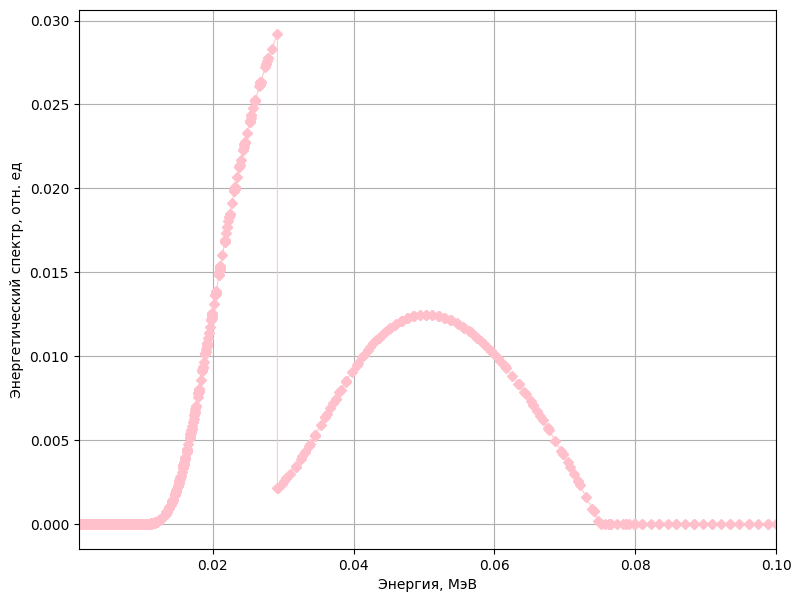

In [3]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [5]:
n = 11

In [6]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

Спектральные характеристики чувствительности каналов

In [10]:
edge_thiknesses = [Material(i).lt(0.6) for i in range(n, 101)]
edge_regions = [R(Material(i+n), edge_thiknesses[i]) for i in range(0, len(edge_thiknesses))]
resp_edges = [val.f() for val in edge_regions]

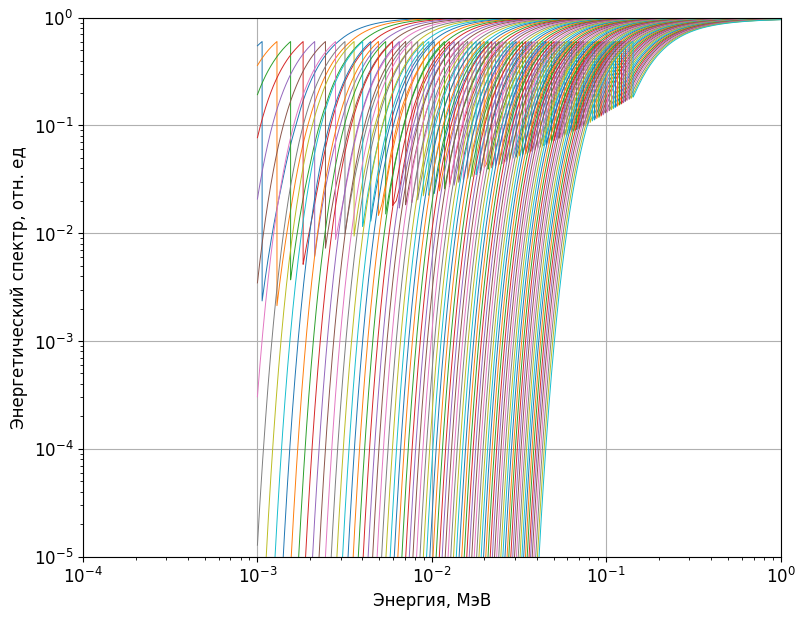

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

In [12]:
from garipov_deconvolution import get_coeff_simpson

In [13]:
signals_simpson = []

for response in resp_edges:
    signals_simpson.append(sum(get_coeff_simpson(response*brem_e, en, EDGE)[0]))

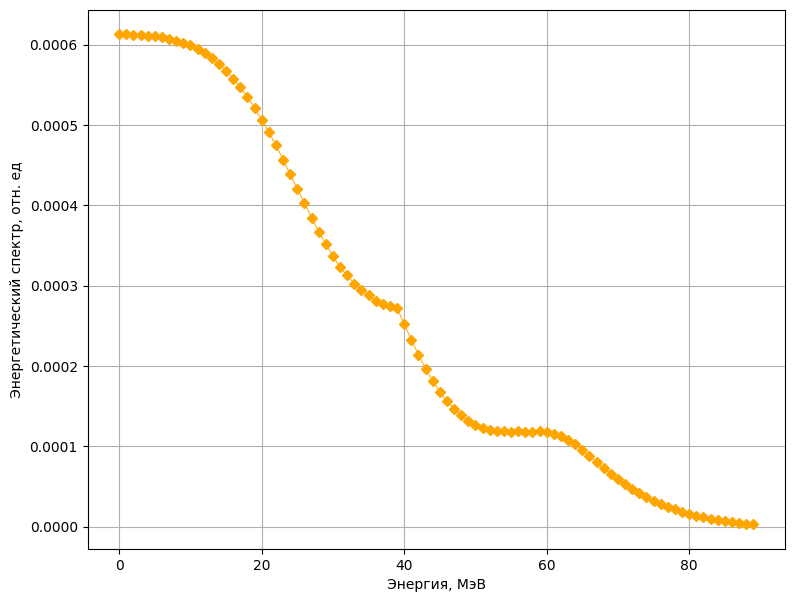

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [15]:
Matrixs = []

for response in resp_edges:
    Matrixs.append(get_coeff_simpson(response, en, EDGE)[0])

In [16]:
from garipov_deconvolution import*

In [18]:
sp = [0 for i in range(len(signals_simpson))]
norm = [0 for i in range(len(signals_simpson))]
decb = [0 for i in range(len(signals_simpson))]
dev = [0 for i in range(len(signals_simpson))]

new_en = get_coeff_simpson(resp_edges[0], en, EDGE)[1]

In [20]:
def Gold(A, b, en, init_spectrum, dec_en, x0=False, it=None, w=False, d=False):
    A = np.array(A)
    b = np.array(b)
    b = b.reshape(len(b), -1)

    def deviation(init_spectrum, dec_spectrum):
        dec_spectrum_on_init_grid = np.interp(en, dec_en, dec_spectrum)
        different = [(i - j) ** 2 for i, j in zip(dec_spectrum_on_init_grid, init_spectrum)]
        init_sq = [val ** 2 for val in init_spectrum]

        def integral_t(different_signal, grid):
            s = 0
            for i in range(1, len(different_signal) - 2):
                s += (grid[i] - grid[i - 1]) * different_signal[i - 1]
            return s

        dev = integral_t(different, en) / integral_t(init_sq, en)
        return dev

    # Если начальное приближение не задано создает вектор-столбец x0 = [1, 1,.., 1]
    if x0:
        previous_x = np.ones((A.shape[1], 1), dtype=np.float64)
    # Транспонирование вектора х0, если он считывается вектором-строкой
    else:
        x0 = float(input('Введите начальное приближение: '))
        previous_x = x0 * np.ones((A.shape[1], 1), dtype=np.float64)
    # Транспонирование вектора b, если он считывается вектором-строкой
    if b.shape[1] != 1:
        b = b.T
    if it is None:
        num_of_iter = int(input('Введите число итераций: '))
    else:
        num_of_iter = it

    if w == False:
        W = np.diag([float(1 ** 2) for i in range(0, len(b))])
    if w == True:
        W = np.diag([float(i) for i in range(0, len(b))])

    current_x = np.ones((A.shape[1], 1), dtype=np.float64)
    norm_list = []
    deviation_list = []

    # Основной цикл алгоритма Голда
    for k in range(0, num_of_iter + 1):
        # Создание матрицы Y = A.T * W.T * W * b
        Y = np.dot(A.T, np.dot(W.T, np.dot(W, b)))
        # Создание матрицы AX = A.T * W.T * W * A * x
        AX = np.dot(A.T, np.dot(W.T, np.dot(W, np.dot(A, previous_x))))
        AX[AX == 0] = np.nextafter(0, 1)*1e20
        current_x = 1.0 * previous_x + (previous_x / AX) * (Y - AX)
        previous_x = current_x

        norm_list.append(linalg.norm(np.dot(A, current_x) - b))
        if d == True:
            deviation_list.append(deviation(init_spectrum, current_x.reshape(1, 1)[0].tolist()) ** 0.5)

    norm = [range(1, num_of_iter + 2), norm_list]

    if d == True:
        dev = [range(1, num_of_iter + 2), deviation_list]
    if d == False:
        dev = deviation(init_spectrum, current_x.reshape(1, -1)[0].tolist())**0.5


    current_x = current_x.reshape(1, -1)
    current_x = current_x[0].tolist()

    return current_x, norm, dev

In [32]:
import time

start_time = time.time()
sp, norm, dev = Gold(Matrixs, signals_simpson, en, brem_e, new_en, 1, 1000000, w=True, d=False)[:3]
print(f'время: {time.time() - start_time}, секунд')

время: 339.6579191684723, секунд


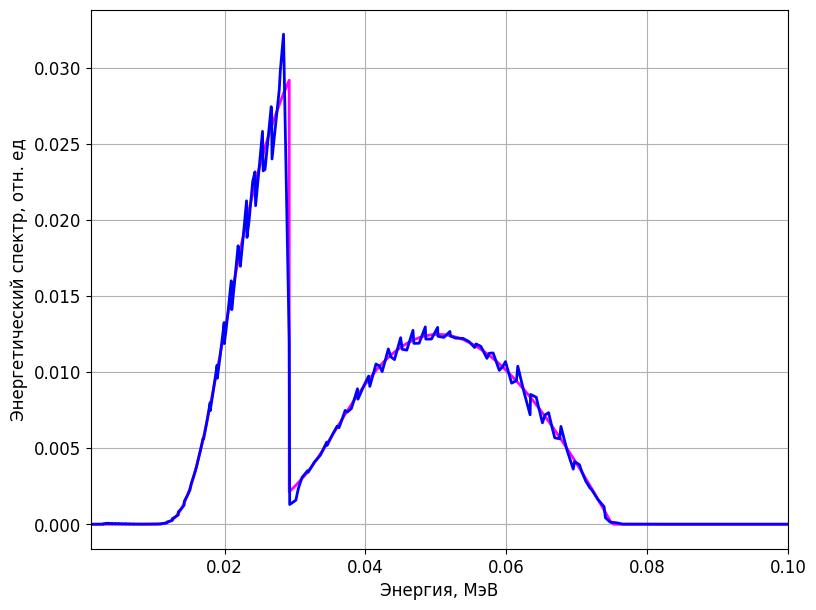

In [33]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [34]:
dev

0.06347604574217695